In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Fri Feb  2 13:51:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:02:00.0 Off |                  N/A |
| 46%   71C    P2             318W / 375W |  14394MiB / 24576MiB |     71%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.min_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1
hp.N = 256
hp.z_activation = F.tanh

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train02.02-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 647784
-rw-r--r-- 1 root root 16493536 Feb  2 13:51 events.out.tfevents.1706869142.d3a062297ae2
-rw-r--r-- 1 root root 37979957 Feb  2 13:40 save_160000
-rw-r--r-- 1 root root 37979957 Feb  2 13:28 save_150000
-rw-r--r-- 1 root root 37979957 Feb  2 13:15 save_140000
-rw-r--r-- 1 root root 37979957 Feb  2 13:03 save_130000
-rw-r--r-- 1 root root 37979957 Feb  2 12:50 save_120000
-rw-r--r-- 1 root root 37979957 Feb  2 12:37 save_110000
-rw-r--r-- 1 root root 37979957 Feb  2 12:25 save_100000
-rw-r--r-- 1 root root 37979741 Feb  2 12:12 save_90000
-rw-r--r-- 1 root root 37979741 Feb  2 12:00 save_80000
-rw-r--r-- 1 root root 37979741 Feb  2 11:47 save_70000
-rw-r--r-- 1 root root 37979741 Feb  2 11:35 save_60000
-rw-r--r-- 1 root root 37979741 Feb  2 11:22 save_50000
-rw-r--r-- 1 root root 37979741 Feb  2 11:09 save_40000
-rw-r--r-- 1 root root 37979741 Feb  2 10:57 save_30000
-rw-r--r-- 1 root root 37979741 Feb  2 10:44 save_20000
-rw-r--r-- 1 root root 37979741 Feb  2 10:31 save_1

### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


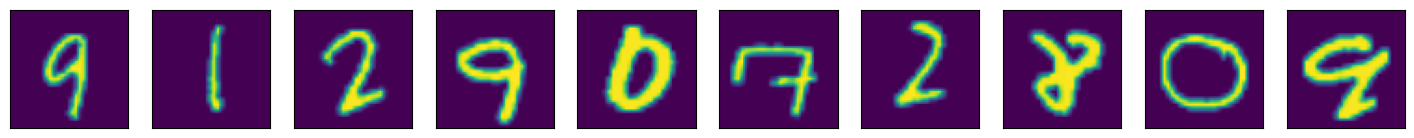

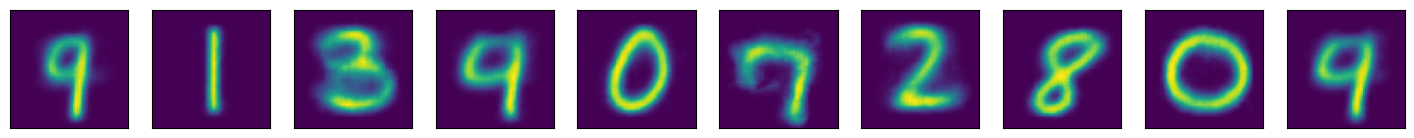

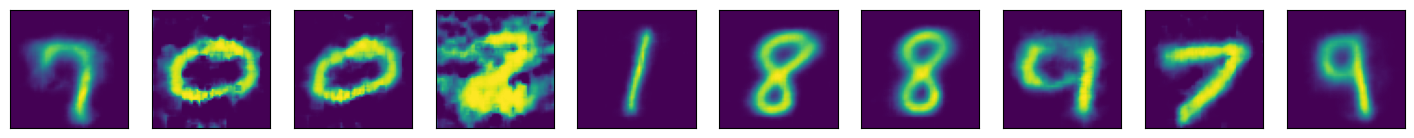

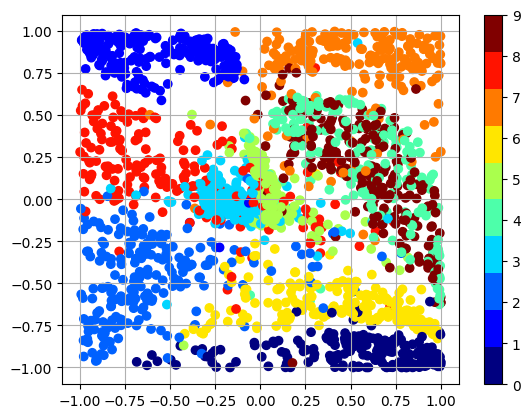

57001
lse_loss 0.021910320967435837
recon_loss 0.11599364131689072
57002
lse_loss 0.0003843098529614508
recon_loss 0.11428658664226532
57003
lse_loss 0.011636577546596527
recon_loss 0.12130741775035858
57004
lse_loss 0.008705376647412777
recon_loss 0.11170397698879242
57005
lse_loss 0.024083377793431282
recon_loss 0.11093016713857651
57006
lse_loss 0.01950829103589058
recon_loss 0.11056509613990784
57007
lse_loss 0.006854851730167866
recon_loss 0.11970396339893341
57008
lse_loss 0.006687598302960396
recon_loss 0.11619561910629272
57009
lse_loss 0.041768305003643036
recon_loss 0.11994566023349762
57010
lse_loss 0.004430393222719431
recon_loss 0.11692114919424057
57011
lse_loss 0.004693183582276106
recon_loss 0.117036834359169
57012
lse_loss 0.0022924751974642277
recon_loss 0.12264604866504669
57013
lse_loss 0.007467400282621384
recon_loss 0.11693914979696274
57014
lse_loss 0.0068784449249506
recon_loss 0.12120559066534042
57015
lse_loss 0.005395274609327316
recon_loss 0.1143504828214645

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

batch = next(iter(test_loader))
data = preprocess(batch)

model = model_list[0]
model.eval()
with torch.no_grad():
    data = model(data, M=hp.M)

plot(data['x'])
plot(data['y'])

with torch.no_grad():
    z = torch.randn(10, hp.z_dim).to(device)
    y = model.sample(z)
    plot(y)
    
import matplotlib.pyplot as plt
_z = data['z'].data.cpu().numpy()
plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
plt.grid()
plt.colorbar()
plt.show()